# ttbar Analysis - Jet-Parton Assignment Training

This is the training notebook for the jet-parton assignment task. The goal is to associate the leading four jets in each event to their associated parent particles. We are trying to assign jets according to the labels in the diagram below:

<img src="utils/ttbar_labels.png" alt="ttbar_labels" width="500"/>


<mark>top<sub>lepton</sub></mark> and <mark>top<sub>hadron</sub></mark> jets do not necessarily correspond to top/antitop, respectively. The <mark>top<sub>lepton</sub></mark> jet is defined as having a lepton/neutrino pair as cousins, where the <mark>top<sub>hadron</sub></mark> jet is defined as having two jets as cousins. The <mark>W</mark> jets are not distinguished from each other.

The strategy for solving this problem is to train a boosted decision tree to find the correct assignments for each jet. Since we consider four jets per event with three unique labels (<mark>W</mark>, <mark>top<sub>lepton</sub></mark>, and <mark>top<sub>hadron</sub></mark>), there are twelve possible combinations of assignments:

<img src="utils/jetcombinations.png" alt="jetcombinations" width="700"/>

The combination with the highest BDT score will be selected for each event.
____

The workflow for this training notebook is outlined as follows:
* Load data and calculate training features and labels using `coffea`/`dask`
* Optimize BDT using $n$-fold cross-validation and track using `mlflow`
* Register best model in `mlflow` model repository

In [1]:
import awkward as ak
import cloudpickle
from coffea.nanoevents import NanoAODSchema
from coffea import processor
import datetime
import hist
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import uproot
import os

import utils

# ML-related imports
from dask.distributed import Client
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import ParameterSampler, train_test_split, KFold, cross_validate
from xgboost import XGBClassifier

In [2]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster, want to use larger number for training)
N_FILES_MAX_PER_SAMPLE = 5

# set to True for DaskExecutor
USE_DASK_PROCESSING = True


### MACHINE LEARNING OPTIONS

# enable Dask (whether to use dask for hyperparameter optimization. currently does not work)
USE_DASK_ML = False

# enable MLFlow logging (to store metrics and models of hyperparameter optimization trials)
USE_MLFLOW = True

# enable MLFlow model logging/registering
MODEL_LOGGING = True
MODEL_REGISTERING = True

# number of events to use for training (more results in higher efficiency, but slower to train)
N_EVENTS_TRAIN = 10000

In [3]:
# get dictionaries for permutation indices, associated labels, and evaluation matrices
# permutation indices correspond to the different possible combinations of jets in an event for correspondence 
# with the W boson, the top quark on the side of hadronic decay, and the top quark on the side of leptonic decay
# evaluation matrix is used to calculate the fraction of matches correct within an event
# permutations_dict, labels_dict, evaluation_matrices = utils.ml.get_permutations_dict(4, 
#                                                                                      include_labels=True, 
#                                                                                      include_eval_mat=True)
# evaluation_matrix = evaluation_matrices[4]
# print(evaluation_matrix)

### Defining a `coffea` Processor

The processor returns the training features and labels we will use in our BDT

In [4]:
# function to create column accumulator from list
def col_accumulator(a):
    return processor.column_accumulator(np.array(a))

processor_base = processor.ProcessorABC
class JetClassifier(processor_base):
    def __init__(self):
        super().__init__()
    
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" etc.
        variation = events.metadata["variation"]  # "nominal" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        xsec_weight = x_sec * lumi / nevts_total
            
        events["pt_nominal"] = 1.0
        pt_variations = ["pt_nominal"] if variation == "nominal" else ["pt_nominal"]
        for pt_var in pt_variations:
            
            # filter electrons, muons, and jets
            selected_electrons = events.Electron[(events.Electron.pt > 30) & (np.abs(events.Electron.eta)<2.1) & 
                                                 (events.Electron.cutBased==4) & (events.Electron.sip3d < 4)]
            selected_muons = events.Muon[(events.Muon.pt > 30) & (np.abs(events.Muon.eta)<2.1) & (events.Muon.tightId) & 
                                         (events.Muon.sip3d < 4) & (events.Muon.pfRelIso04_all < 0.15)]
            jet_filter = (events.Jet.pt > 30) & (np.abs(events.Jet.eta) < 2.4) & (events.Jet.isTightLeptonVeto)
            selected_jets = events.Jet[jet_filter]
            selected_genpart = events.GenPart
            even = (events.event%2==0)
            
            # single lepton requirement
            event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
            # require at least 4 jets
            event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
            # require at least one jet above B_TAG_THRESHOLD
            B_TAG_THRESHOLD = 0.5
            event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)
            
            # apply event filters
            selected_events = events[event_filters]
            selected_electrons = selected_electrons[event_filters]
            selected_muons = selected_muons[event_filters]
            selected_jets = selected_jets[event_filters]
            selected_genpart = selected_genpart[event_filters]
            even = even[event_filters]
            
            ### only consider 4j2b (signal) region
            region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2 # at least two b-tagged jets
            selected_jets_region = selected_jets[region_filter][:,:4] # only keep top 4 jets
            selected_electrons_region = selected_electrons[region_filter]
            selected_muons_region = selected_muons[region_filter]
            selected_genpart_region = selected_genpart[region_filter]
            even = even[region_filter]
            
            # filter events and calculate labels
            jets, electrons, muons, labels, even = utils.ml.training_filter(selected_jets_region, 
                                                                            selected_electrons_region, 
                                                                            selected_muons_region, 
                                                                            selected_genpart_region,
                                                                            even)
            
            
            # calculate mbjj
            # reconstruct hadronic top as bjj system with largest pT
            # the jet energy scale / resolution effect is not propagated to this observable at the moment
            trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
            trijet_labels = ak.combinations(labels, 3, fields=["j1", "j2", "j3"])
            trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
            trijet["label"] = trijet_labels.j1 + trijet_labels.j2 + trijet_labels.j3
            trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
            trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
            # pick trijet candidate with largest pT and calculate mass of system
            trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
            trijet_label = trijet["label"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)]
            observable = ak.flatten(trijet_mass)
            trijet_label = ak.flatten(trijet_label)
            
            # calculate features and labels
            features, labels, which_combination = utils.ml.get_training_set(jets, electrons, muons, labels)
    
            
        output = {"nevents": {events.metadata["dataset"]: len(events)},
                  "features": col_accumulator(features.tolist()),
                  "labels": col_accumulator(labels.tolist()),
                  "observable": col_accumulator(observable.tolist()),
                  "even": col_accumulator(even.tolist()),
                  "trijet_label": col_accumulator(trijet_label.tolist()),}
            
        return output
        
    def postprocess(self, accumulator):
        return accumulator

### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [5]:
fileset = utils.file_input.construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False)

# get rid of everything except ttbar__nominal for training purposes
fileset = {"ttbar__nominal": fileset["ttbar__nominal"]}

### Execute the data delivery pipeline

In [6]:
NanoAODSchema.warn_missing_crossrefs = False

if USE_DASK_PROCESSING:
    cloudpickle.register_pickle_by_value(utils)
    executor = processor.DaskExecutor(client=utils.clients.get_client(utils.config_training["global"]["AF"]))
else:
    executor = processor.FuturesExecutor(workers=utils.config_training["benchmarking"]["NUM_CORES"])
    
run = processor.Runner(executor=executor, schema=NanoAODSchema, savemetrics=True, metadata_cache={}, 
                       chunksize=utils.config_training["benchmarking"]["CHUNKSIZE"])

# preprocess
filemeta = run.preprocess(fileset, treename="Events")

# process
output, metrics = run(fileset, 
                      "Events", 
                      processor_instance = JetClassifier())

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [7]:
# grab features and labels and convert to np array
features = output['features'].value
labels = output['labels'].value
even = output['even'].value
observable = output['observable'].value

labels = labels.reshape((len(labels),))
even = np.repeat(even, 12) # twelve permutations for each event

The key for the labeling scheme is as follows

* 1: all jet assignments are correct
* -1: some jet assignments are correct (one or two are correct, others are incorrect)
* 0: all jet assignments are incorrect

There are twelve combinations for each event, so each event will have 1 correct combination, 2 completely incorrect combinations, and 9 partially correct combinations.

# Histograms of Training Variables
To vizualize the separation power of the different variables, histograms are created for each of the three labels. Only `all_correct` and `none_correct` are used for training purposes.

In [8]:
# separate by label for plotting
all_correct = features[labels==1,:]
some_correct = features[labels==-1,:]
none_correct = features[labels==0,:]

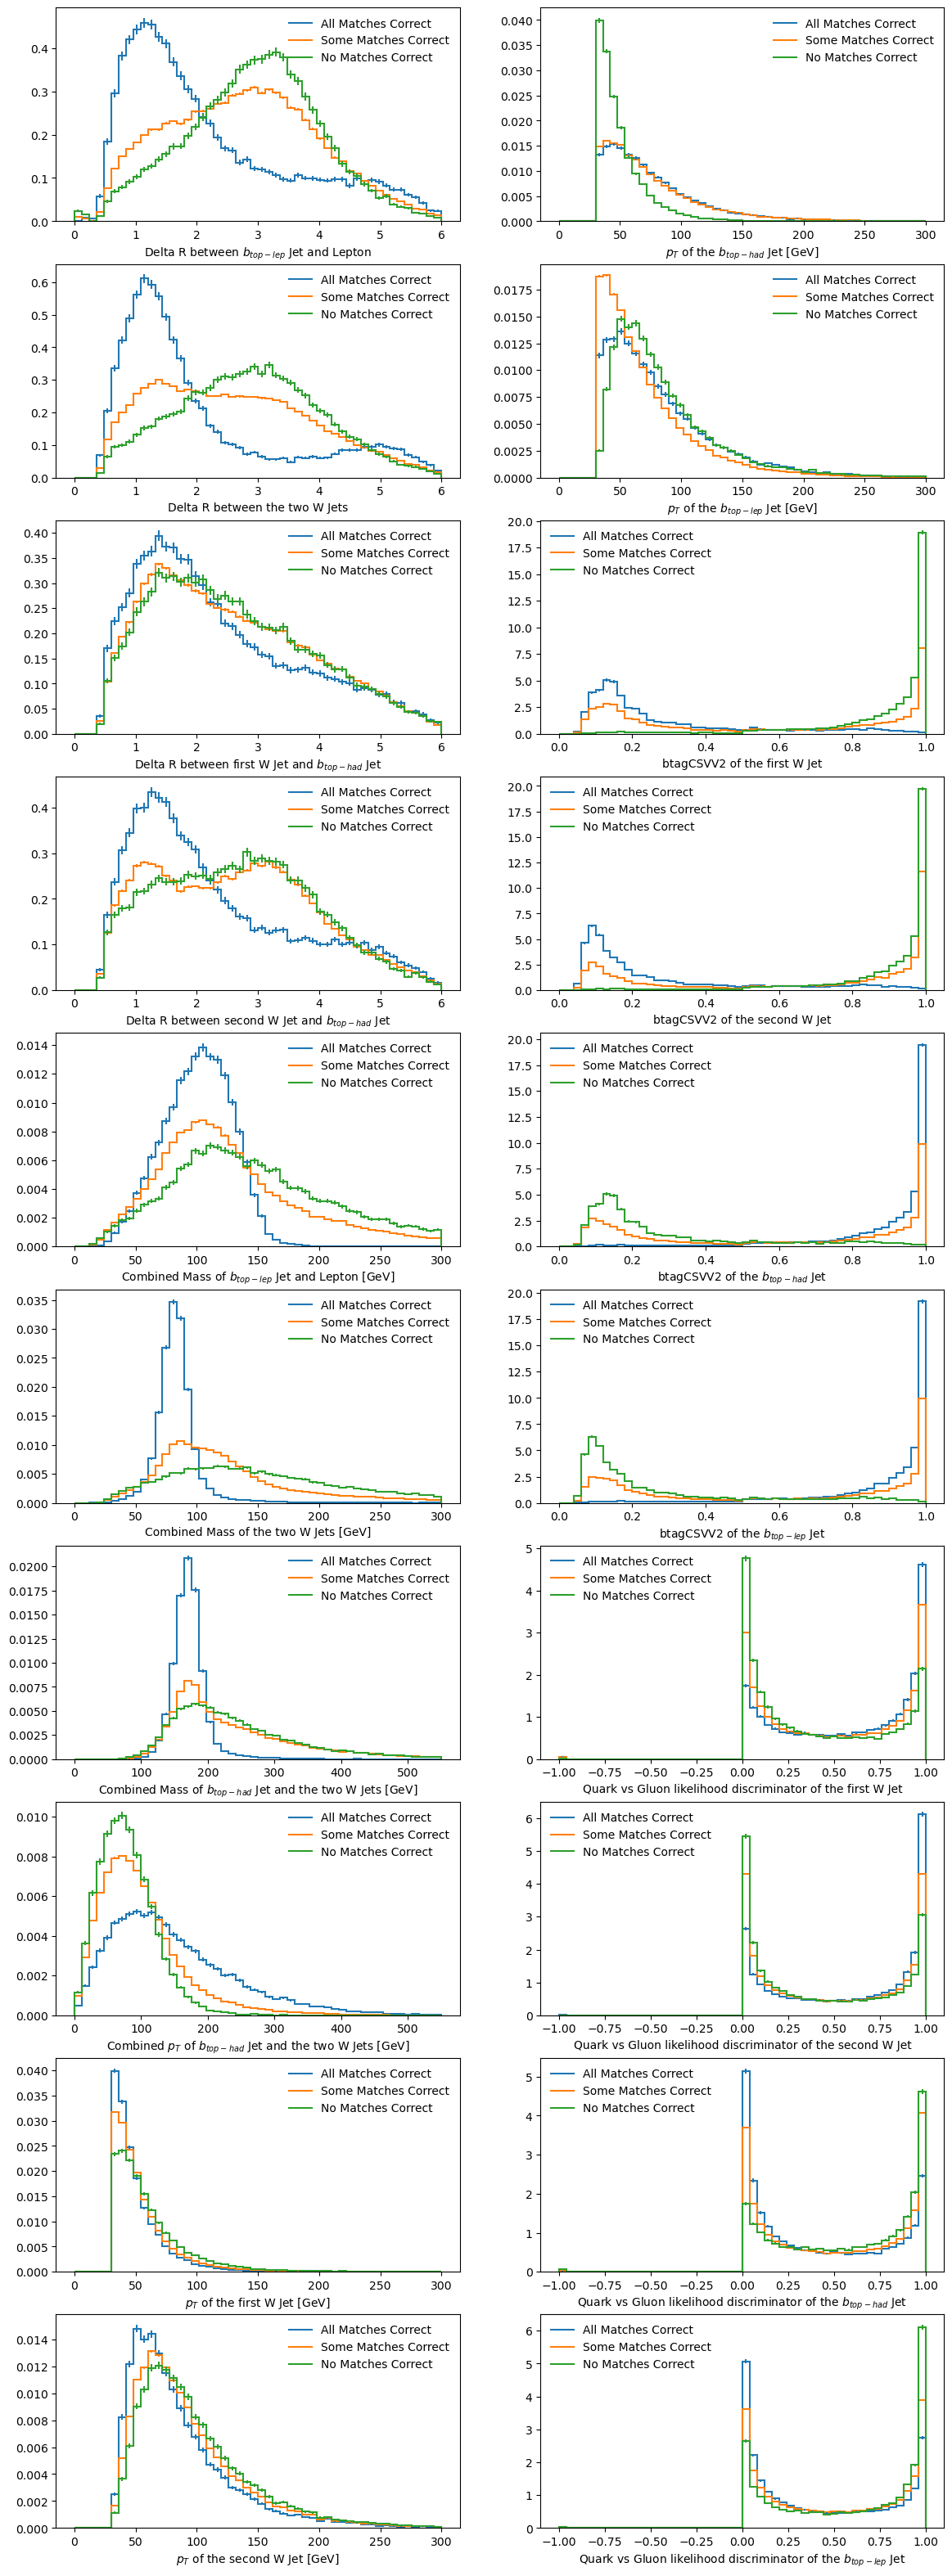

In [9]:
# make plots
utils.plotting.plot_training_variables(all_correct, some_correct, none_correct)

# Model Optimization

The model used here is `xgboost`'s gradient-boosted decision tree (`XGBClassifier`). Hyperparameter optimization is performed using random selection from a sample space of hyperparameters then testing model fits in a parallelized manner using `dask`. Optional `mlflow` logging is included.

In [ ]:
# grab features and labels and convert to np array
features = output['features'].value
labels = output['labels'].value
labels[labels==-1]=0 # partially correct = wrong
even = output['even'].value

features = features.reshape((int(features.shape[0]/12),12,20))
labels = labels.reshape((int(labels.shape[0]/12),12))

shuffle_indices = np.array(range(features.shape[0])).astype(int)
np.random.shuffle(shuffle_indices)

features = features[shuffle_indices]
labels = labels[shuffle_indices]
which_combination = np.argmax(labels,axis=-1)
even = even[shuffle_indices]

features_even = features[even]
features_even = features_even.reshape((int(12*features_even.shape[0]),20))
labels_even = labels[even]
labels_even = labels_even.reshape((int(12*labels_even.shape[0]),))
which_combination_even = which_combination[even]

features_odd = features[np.invert(even)]
features_odd = features_odd.reshape((int(12*features_odd.shape[0]),20))
labels_odd = labels[np.invert(even)]
labels_odd = labels_odd.reshape((int(12*labels_odd.shape[0]),))
which_combination_odd = which_combination[np.invert(even)]

print("features_even.shape = ", features_even.shape)
print("features_odd.shape = ", features_odd.shape)

N_EVENTS_TRAIN = min(min(int(features_odd.shape[0]/12), N_EVENTS_TRAIN), int(features_even.shape[0]/12))

In [ ]:
# set up trials
if USE_MLFLOW:
    
    os.environ['MLFLOW_TRACKING_TOKEN'] = "" # enter token here
    os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow-demo.software-dev.ncsa.illinois.edu"
    
    mlflow.set_tracking_uri('https://mlflow-demo.software-dev.ncsa.illinois.edu') 
    mlflow.set_experiment("optimize-reconstruction-bdt-00") # this will create the experiment if it does not yet exist

    # grab experiment
    current_experiment=dict(mlflow.get_experiment_by_name("optimize-reconstruction-bdt-00"))
    experiment_id=current_experiment['experiment_id']
    print("experiment_id = ", experiment_id)

    # create runs ahead of time (avoids conflicts when parallelizing mlflow logging)
    run_id_list=[]
    for n in range(N_TRIALS*2):
        run = MlflowClient().create_run(experiment_id=experiment_id, run_name=f"run-{n}")
        run_id_list.append(run.info.run_id)

In [ ]:
sampler = ParameterSampler({'max_depth': np.arange(1,81,10,dtype=int), 
                            'n_estimators': np.arange(1,501,50,dtype=int), 
                            'learning_rate': np.linspace(0.01, 1, 10),
                            'min_child_weight': np.logspace(-1, 3, 20), 
                            'reg_lambda': [0, 0.25, 0.5, 0.75, 1], 
                            'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
                            'gamma': np.logspace(-4, 1, 20),
                            'tree_method': ["hist"],}, 
                            n_iter = N_TRIALS, 
                            random_state=2) 

samples_even = list(sampler)
samples_odd = list(sampler)

# add additional info to each trial
for i in range(N_TRIALS):
    samples_even[i]['trial_num'] = i
    samples_even[i]['parity'] = 'even' # categorizes this trial as for even event numbers
    
    samples_odd[i]['trial_num'] = i
    samples_odd[i]['parity'] = 'odd' # categorizes this trial as for odd event numbers
    
    if USE_MLFLOW: 
        samples_even[i]['run_id'] = run_id_list[i]
        samples_odd[i]['run_id'] = run_id_list[i+N_TRIALS]
    
print("Example of Trial Parameters: ")
samples_even[0]

In [ ]:
if USE_MLFLOW:
    # set mlflowclient
    mlflowclient = MlflowClient()
else: 
    mlflowclient = None

In [ ]:
def modified_cross_validation(model, 
                              features, labels, 
                              evaluation_matrix, n_folds=2):
            
    features = features.reshape((int(features.shape[0]/12),12,20))
    labels = labels.reshape((int(labels.shape[0]/12),12))
    which_combination = np.argmax(labels, axis=-1)
        
    shuffle_ind = np.array(range(features.shape[0])).astype(int)
    np.random.shuffle(shuffle_ind)
    splits = np.array_split(shuffle_ind, n_folds)
    
    test_accuracy = np.zeros(n_folds)
    test_precision = np.zeros(n_folds)
    test_recall = np.zeros(n_folds)
    test_f1 = np.zeros(n_folds)
    test_roc_auc = np.zeros(n_folds)
    test_jet_score = np.zeros(n_folds)
    
    train_accuracy = np.zeros(n_folds)
    train_precision = np.zeros(n_folds)
    train_recall = np.zeros(n_folds)
    train_f1 = np.zeros(n_folds)
    train_roc_auc = np.zeros(n_folds)
    train_jet_score = np.zeros(n_folds)
    
    for n in range(n_folds):
        
        features_test = features[splits[n]]
        features_test = features_test.reshape((12*features_test.shape[0],20))
        labels_test = labels[splits[n]]
        labels_test = labels_test.reshape((12*labels_test.shape[0],))
        which_combination_test = which_combination[splits[n]]
        
        train_ind = np.concatenate([splits[i] for i in range(n_folds) if not i==n])
        
        features_train = features[train_ind]
        features_train = features_train.reshape((12*features_train.shape[0],20))
        labels_train = labels[train_ind]
        labels_train = labels_train.reshape((12*labels_train.shape[0],))
        which_combination_train = which_combination[train_ind]
                
        model.fit(features_train, labels_train)
        
        test_predictions = model.predict(features_test)
        train_predictions = model.predict(features_train)
        
        test_accuracy[n] = accuracy_score(labels_test, test_predictions)
        test_precision[n] = precision_score(labels_test, test_predictions)
        test_recall[n] = recall_score(labels_test, test_predictions)
        test_f1[n] = f1_score(labels_test, test_predictions)
        test_roc_auc[n] = roc_auc_score(labels_test, test_predictions)
        
        train_accuracy[n] = accuracy_score(labels_train, train_predictions)
        train_precision[n] = precision_score(labels_train, train_predictions)
        train_recall[n] = recall_score(labels_train, train_predictions)
        train_f1[n] = f1_score(labels_train, train_predictions)
        train_roc_auc[n] = roc_auc_score(labels_train, train_predictions)
        
        
        test_predictions_prob = model.predict_proba(features_test)[:,1]
        train_predictions_prob = model.predict_proba(features_train)[:,1]
        test_predictions_prob = test_predictions_prob.reshape((int(test_predictions_prob.shape[0]/12),12))
        train_predictions_prob = train_predictions_prob.reshape((int(train_predictions_prob.shape[0]/12),12))
        
        train_predicted_combination = np.argmax(train_predictions_prob,axis=1)
        scores = np.zeros(len(which_combination_train))
        zipped = list(zip(which_combination_train.tolist(), train_predicted_combination.tolist()))
        for i in range(len(which_combination_train)):
            scores[i] = evaluation_matrix[zipped[i]]
        train_jet_score[n] = sum(scores)/len(scores)
        
        test_predicted_combination = np.argmax(test_predictions_prob,axis=1)
        scores = np.zeros(len(which_combination_test))
        zipped = list(zip(which_combination_test.tolist(), test_predicted_combination.tolist()))
        for i in range(len(which_combination_test)):
            scores[i] = evaluation_matrix[zipped[i]]
        test_jet_score[n] = sum(scores)/len(scores)
        
    
    return {"test_accuracy": test_accuracy, 
            "test_precision": test_precision, 
            "test_recall": test_recall,
            "test_f1": test_f1,
            "test_roc_auc": test_roc_auc,
            "test_jet_score": test_jet_score,
            "train_accuracy": train_accuracy, 
            "train_precision": train_precision, 
            "train_recall": train_recall,
            "train_f1": train_f1,
            "train_roc_auc": train_roc_auc, 
            "train_jet_score": train_jet_score,
            "model": model
           }

In [ ]:
def fit_model(params, 
              features, 
              labels, 
              evaluation_matrix,
              n_folds,
              mlflowclient=None,
              use_mlflow=False,
              log_models=False,
              verbose=False): 
                            
    if use_mlflow:
        
        run_id = params["run_id"]
        
        if verbose: print("run_id = ", run_id)
        
        for param_name, value in params.items():
            mlflowclient.log_param(run_id, param_name, value)
            
            if verbose: print(f"logged param: {param_name} = {value}")
            
    # remove parameters that are not used for XGBClassifier
    params_copy = params.copy()
    params_copy.pop("trial_num")
    params_copy.pop("parity")
    if use_mlflow: params_copy.pop("run_id")
    
    # initialize model with current trial paramters
    model = XGBClassifier(random_state=5, 
                          nthread=-1,
                          **params_copy) 

    # perform n-fold cross-validation
    result = modified_cross_validation(model, features, labels,
                                      evaluation_matrix, n_folds=n_folds)
    
    if use_mlflow:
        for metric, value in result.items():
            if not metric=="model":
                mlflowclient.log_metric(run_id, metric, np.average(value))
                if verbose: print(f"logged metric: {metric} = {np.average(value)}")

        # manually end run
        mlflowclient.set_terminated(run_id)
        
        if log_models:
            signature = infer_signature(features, result["model"].predict(features))
            with mlflow.start_run(run_id=run_id, nested=True) as run:
                mlflow.xgboost.log_model(result["model"], "model", signature=signature)
            result.pop("model")
                
    if not log_models:
        return {"score": np.average(result["test_jet_score"]),
                "full_result": result}
    return {"score": np.average(result["test_jet_score"])}

In [ ]:
# function to provide necessary environment variables to workers
def initialize_mlflow(): 
    
    os.environ['MLFLOW_TRACKING_TOKEN'] = "" # enter token here
    os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow-demo.software-dev.ncsa.illinois.edu"
    
    mlflow.set_tracking_uri('https://mlflow-demo.software-dev.ncsa.illinois.edu') 
    mlflow.set_experiment("optimize-reconstruction-bdt-00")

In [ ]:
if USE_DASK_ML:
    start_time = time.time() 
    
    client = utils.get_client()
    if USE_MLFLOW:
        client.run(initialize_mlflow)
    
    futures = client.map(fit_model,
                         samples_even, 
                         features=features_even[:N_EVENTS_TRAIN*12], 
                         labels=labels_even[:N_EVENTS_TRAIN*12],
                         evaluation_matrix=evaluation_matrix,
                         n_folds=N_FOLD,
                         mlflowclient=mlflowclient,
                         use_mlflow=USE_MLFLOW,
                         log_models=MODEL_LOGGING) 

    res = client.gather(futures)
    time_elapsed = time.time() - start_time
    
else:
    start_time = time.time() 
    res = []
    for i in range(len(samples_even)):
        print("_____________________________________________________________")
        print(i)
        print(samples_even[i])
        res.append(fit_model(samples_even[i], 
                             features=features_even[:N_EVENTS_TRAIN*12],
                             labels=labels_even[:N_EVENTS_TRAIN*12], 
                             evaluation_matrix=evaluation_matrix,
                             n_folds=N_FOLD,
                             mlflowclient=mlflowclient,
                             use_mlflow=USE_MLFLOW,
                             log_models=MODEL_LOGGING))
        print(res[i])
    time_elapsed = time.time() - start_time

print("Hyperparameter optimization took time = ", time_elapsed)
print()

scores = [res[i]["score"] for i in range(len(res))]
best_parameters_even = samples_even[np.argmax(scores)]
print("best_parameters_even = ")
best_parameters_even

In [ ]:
if MODEL_LOGGING and USE_MLFLOW:
    best_run_id = samples_even[np.argmax(scores)]["run_id"]
    best_model_path = f'runs:/{best_run_id}/model'
    best_model_even = mlflow.xgboost.load_model(best_model_path)
    
    # register best model in mlflow model repository
    if MODEL_REGISTERING:
        result = mlflow.register_model(best_model_path, "reconstruction-bdt")

else:
    best_model_even = res[np.argmax(scores)]["full_result"]["model"]
    
best_model_even.save_model(f"models/model_{datetime.datetime.today().strftime('%y%m%d')}_even.json")

In [ ]:
if USE_DASK_ML:
    start_time = time.time() 
    
    client = utils.get_client()
    client.run(initialize_mlflow)
    
    futures = client.map(fit_model,
                         samples_odd, 
                         features=features_odd[:N_EVENTS_TRAIN*12], 
                         labels=labels_odd[:N_EVENTS_TRAIN*12],
                         evaluation_matrix=evaluation_matrix,
                         n_folds=N_FOLD,
                         mlflowclient=mlflowclient,
                         use_mlflow=USE_MLFLOW,
                         log_models=MODEL_LOGGING) 

    res = client.gather(futures)
    time_elapsed = time.time() - start_time
    
else:
    start_time = time.time() 
    res = []
    for i in range(len(samples_odd)):
        print("_____________________________________________________________")
        print(i)
        print(samples_odd[i])
        res.append(fit_model(samples_odd[i], 
                             features=features_odd[:N_EVENTS_TRAIN*12],
                             labels=labels_odd[:N_EVENTS_TRAIN*12], 
                             evaluation_matrix=evaluation_matrix,
                             n_folds=N_FOLD,
                             mlflowclient=mlflowclient,
                             use_mlflow=USE_MLFLOW,
                             log_models=MODEL_LOGGING))
        print(res[i])
    time_elapsed = time.time() - start_time

print("Hyperparameter optimization took time = ", time_elapsed)
print()

scores = [res[i]["score"] for i in range(len(res))]
best_parameters_odd = samples_odd[np.argmax(scores)]
print("best_parameters_odd = ")
best_parameters_odd

In [ ]:
if MODEL_LOGGING and USE_MLFLOW:
    best_run_id = samples_odd[np.argmax(scores)]["run_id"]
    best_model_path = f'runs:/{best_run_id}/model'
    best_model_odd = mlflow.xgboost.load_model(best_model_path)
    
    # register best model in mlflow model repository
    if MODEL_REGISTERING:
        result = mlflow.register_model(best_model_path, "reconstruction-bdt")

else:
    best_model_odd = res[np.argmax(scores)]["full_result"]["model"]
    
best_model_odd.save_model(f"models/model_{datetime.datetime.today().strftime('%y%m%d')}_odd.json")

# Evaluation with Optimized Model

In [ ]:
# generating Triton config file
config_txt = utils.generate_triton_config("reconstruction_bdt_xgb", 
                                          20, 
                                          predict_proba=True)
print(config_txt)

In [ ]:
!mkdir reconstruction_bdt_xgb

In [ ]:
with open(f'reconstruction_bdt_xgb/config.pbtxt', 'w') as the_file:
    the_file.write(config_txt)

In [ ]:
!mkdir reconstruction_bdt_xgb/1

In [ ]:
best_model_even.save_model("reconstruction_bdt_xgb/1/xgboost.model")

In [ ]:
!mkdir reconstruction_bdt_xgb/2

In [ ]:
best_model_even.save_model("reconstruction_bdt_xgb/2/xgboost.model")

If you are using UNL open data, you can upload the model repository to the Triton server using `mc` in the command line:

```
mc alias set triton http://$BUCKET_HOST $AWS_ACCESS_KEY_ID $AWS_SECRET_ACCESS_KEY
mc cp -r reconstruction_bdt_xgb triton/$BUCKET_NAME/reconstruction_bdt_xgb/
```

The server may need to be restarted in order to load the model.

In [ ]:
# remove model directory after uploading to triton
!rm -r reconstruction_bdt_xgb

### Evaluation with Optimized Model

In [ ]:
# make predictions
train_predicted = best_model_even.predict(features_even)
train_predicted_prob = best_model_even.predict_proba(features_even)[:, 1]
val_predicted = best_model_even.predict(features_odd)
val_predicted_prob = best_model_even.predict_proba(features_odd)[:, 1]

In [ ]:
train_accuracy = accuracy_score(labels_even, train_predicted).round(3)
train_precision = precision_score(labels_even, train_predicted).round(3)
train_recall = recall_score(labels_even, train_predicted).round(3)
train_f1 = f1_score(labels_even, train_predicted).round(3)
train_aucroc = roc_auc_score(labels_even, train_predicted_prob).round(3)
print("Training Accuracy = ", train_accuracy)
print("Training Precision = ", train_precision)
print("Training Recall = ", train_recall)
print("Training f1 = ", train_f1)
print("Training AUC = ", train_aucroc)
print()

val_accuracy = accuracy_score(labels_odd, val_predicted).round(3)
val_precision = precision_score(labels_odd, val_predicted).round(3)
val_recall = recall_score(labels_odd, val_predicted).round(3)
val_f1 = f1_score(labels_odd, val_predicted).round(3)
val_aucroc = roc_auc_score(labels_odd, val_predicted_prob).round(3)
print("Validation Accuracy = ", val_accuracy)
print("Validation Precision = ", val_precision)
print("Validation Recall = ", val_recall)
print("Validation f1 = ", val_f1)
print("Validation AUC = ", val_aucroc)

In [ ]:
val_predicted_prob = val_predicted_prob.reshape((int(len(val_predicted_prob)/12),12))
val_predicted_combination = np.argmax(val_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_odd))
zipped = list(zip(which_combination_odd.tolist(), val_predicted_combination.tolist()))
for i in range(len(which_combination_odd)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Validation Jet Score = ", score)

print("How many events are 100% correct: ", sum(scores==1)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==1)/12)
print("How many events are 50% correct: ", sum(scores==0.5)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.5)/12)
print("How many events are 25% correct: ", sum(scores==0.25)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.25)/12)
print("How many events are 0% correct: ", sum(scores==0)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0)/12)

train_predicted_prob = train_predicted_prob.reshape((int(len(train_predicted_prob)/12),12))
train_predicted_combination = np.argmax(train_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_even))
zipped = list(zip(which_combination_even.tolist(), train_predicted_combination.tolist()))
for i in range(len(which_combination_even)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Training Jet Score = ", score)

In [ ]:
# make predictions
train_predicted = best_model_odd.predict(features_odd)
train_predicted_prob = best_model_odd.predict_proba(features_odd)[:, 1]
val_predicted = best_model_odd.predict(features_even)
val_predicted_prob = best_model_odd.predict_proba(features_even)[:, 1]

In [ ]:
train_accuracy = accuracy_score(labels_odd, train_predicted).round(3)
train_precision = precision_score(labels_odd, train_predicted).round(3)
train_recall = recall_score(labels_odd, train_predicted).round(3)
train_f1 = f1_score(labels_odd, train_predicted).round(3)
train_aucroc = roc_auc_score(labels_odd, train_predicted_prob).round(3)
print("Training Accuracy = ", train_accuracy)
print("Training Precision = ", train_precision)
print("Training Recall = ", train_recall)
print("Training f1 = ", train_f1)
print("Training AUC = ", train_aucroc)
print()

val_accuracy = accuracy_score(labels_even, val_predicted).round(3)
val_precision = precision_score(labels_even, val_predicted).round(3)
val_recall = recall_score(labels_even, val_predicted).round(3)
val_f1 = f1_score(labels_even, val_predicted).round(3)
val_aucroc = roc_auc_score(labels_even, val_predicted_prob).round(3)
print("Validation Accuracy = ", val_accuracy)
print("Validation Precision = ", val_precision)
print("Validation Recall = ", val_recall)
print("Validation f1 = ", val_f1)
print("Validation AUC = ", val_aucroc)

In [ ]:
val_predicted_prob = val_predicted_prob.reshape((int(len(val_predicted_prob)/12),12))
val_predicted_combination = np.argmax(val_predicted_prob,axis=1)
    
scores = np.zeros(len(which_combination_even))
zipped = list(zip(which_combination_even.tolist(), val_predicted_combination.tolist()))
for i in range(len(which_combination_even)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Validation Jet Score = ", score)

print("How many events are 100% correct: ", sum(scores==1)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==1)/12)
print("How many events are 50% correct: ", sum(scores==0.5)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.5)/12)
print("How many events are 25% correct: ", sum(scores==0.25)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0.25)/12)
print("How many events are 0% correct: ", sum(scores==0)/len(scores), ", Random = ",sum(evaluation_matrix[0,:]==0)/12)

train_predicted_prob = train_predicted_prob.reshape((int(len(train_predicted_prob)/12),12))
train_predicted_combination = np.argmax(train_predicted_prob,axis=1)

scores = np.zeros(len(which_combination_odd))
zipped = list(zip(which_combination_odd.tolist(), train_predicted_combination.tolist()))
for i in range(len(which_combination_odd)):
    scores[i] = evaluation_matrix[zipped[i]]
        
score = sum(scores)/len(scores)
print("Training Jet Score = ", score)

### m_bjj test (Compare BDT output to previous method)

In [ ]:
best_model_even = XGBClassifier()
best_model_even.load_model(f"models/model_{datetime.datetime.today().strftime('%y%m%d')}_even.json")
best_model_odd = XGBClassifier()
best_model_odd.load_model(f"models/model_{datetime.datetime.today().strftime('%y%m%d')}_odd.json")

In [ ]:
# grab features and labels and convert to np array
features = output['features'].value
labels = output['labels'].value
even = output['even'].value
observable = output['observable'].value
even = np.repeat(even, 12)

In [ ]:
features_even = features[even]
labels_even = labels[even]
features_odd = features[np.invert(even)]
labels_odd = labels[np.invert(even)]

labels_even = labels_even.reshape((len(labels_even),))
labels_odd = labels_odd.reshape((len(labels_odd),))

In [ ]:
features_even_reshaped = features_even.reshape((int(len(features_even)/12),12,20))
top_mass_candidates_even = features_even_reshaped[:,:,6]
features_odd_reshaped = features_odd.reshape((int(len(features_odd)/12),12,20))
top_mass_candidates_odd = features_odd_reshaped[:,:,6]

observable_list = observable.astype(np.float32).tolist()
all_correct_top_mass_even = features_even[labels_even==1,6]
all_correct_top_mass_odd = features_odd[labels_odd==1,6]

In [ ]:
#### mass histogram ####

# binning
combinedmass_low = 0.0
combinedmass_high = 1500.0
combinedmass_numbins = 200

legendlist=["Truth","Jet Triplet with Largest pT","BDT"]

# define histogram
h = hist.Hist(
    hist.axis.Regular(combinedmass_numbins, combinedmass_low, combinedmass_high, 
                      name="combinedmass", label="Reconstructed Top Mass [GeV]", flow=False),
    hist.axis.StrCategory(legendlist, name="truthlabel", label="Truth Label", growth=True),
)

# fill histogram
h.fill(combinedmass = all_correct_top_mass_even, truthlabel="Truth")
h.fill(combinedmass = all_correct_top_mass_odd, truthlabel="Truth")
h.fill(combinedmass = observable_list, truthlabel="Jet Triplet with Largest pT")

# fill in odd predictions
predictions = best_model_even.predict_proba(features_odd)[:,0]
predictions = predictions.reshape((int(len(predictions)/12),12))
which_combination = np.argmin(predictions,axis=-1)
    
top_mass_odd = np.zeros(features_odd_reshaped.shape[0])
for j in range(len(top_mass_odd)):
    top_mass_odd[j] = top_mass_candidates_odd[j,which_combination[j]]
        
h.fill(combinedmass = top_mass_odd, truthlabel="BDT")

# fill in even predictions
predictions = best_model_odd.predict_proba(features_even)[:,0]
predictions = predictions.reshape((int(len(predictions)/12),12))
which_combination = np.argmin(predictions,axis=-1)
    
top_mass_even = np.zeros(features_even_reshaped.shape[0])
for j in range(len(top_mass_even)):
    top_mass_even[j] = top_mass_candidates_even[j,which_combination[j]]
        
h.fill(combinedmass = top_mass_even, truthlabel="BDT")

fig,ax = plt.subplots(1,1,figsize=(8,8))
h.plot(ax=ax)
ax.legend(legendlist)
ax.set_title("Reconstructed Top Mass")
ax.set_xlim([80,500])
fig.show()